In [206]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import AxesGrid
import mpl_toolkits as mpl

#import warnings
#warnings.filterwarnings("ignore")

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

s=6
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#plt stuff
plt.rcParams["figure.figsize"] = (20,10)

# Model

In [207]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)

mnist_model = NN()
loss_function = torch.nn.CrossEntropyLoss()
mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)

MNIST_PATH = "../trained_weights/MNIST/MNIST_weights_seed={}.pth".format(s)

In [208]:
mnist_model.load_state_dict(torch.load(MNIST_PATH), strict=False)
mnist_model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=10, bias=True)
)

# Laplace approximation of the weights with DiagHessian()

In [209]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [210]:
MNIST_NN_Std_prec_1 = torch.load('Hessians/MNIST/Hessian_prec1_seed{}.pth'.format(s))
MNIST_NN_Std_prec_01 = torch.load('Hessians/MNIST/Hessian_prec01_seed{}.pth'.format(s))
MNIST_NN_Std_prec_001 = torch.load('Hessians/MNIST/Hessian_prec001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_0001 = torch.load('Hessians/MNIST/Hessian_prec0001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_00001 = torch.load('Hessians/MNIST/Hessian_prec00001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_000001 = torch.load('Hessians/MNIST/Hessian_prec000001_seed{}.pth'.format(s))

# Analyzing the first conv-layer
* visualization of the uncertainty in the 32 kernels
* visualization of the weights in the 32 kerlens
* histogram of the uncertainty to see the distribution
* correlation of the uncertainty and the weights

### Uncertaintys

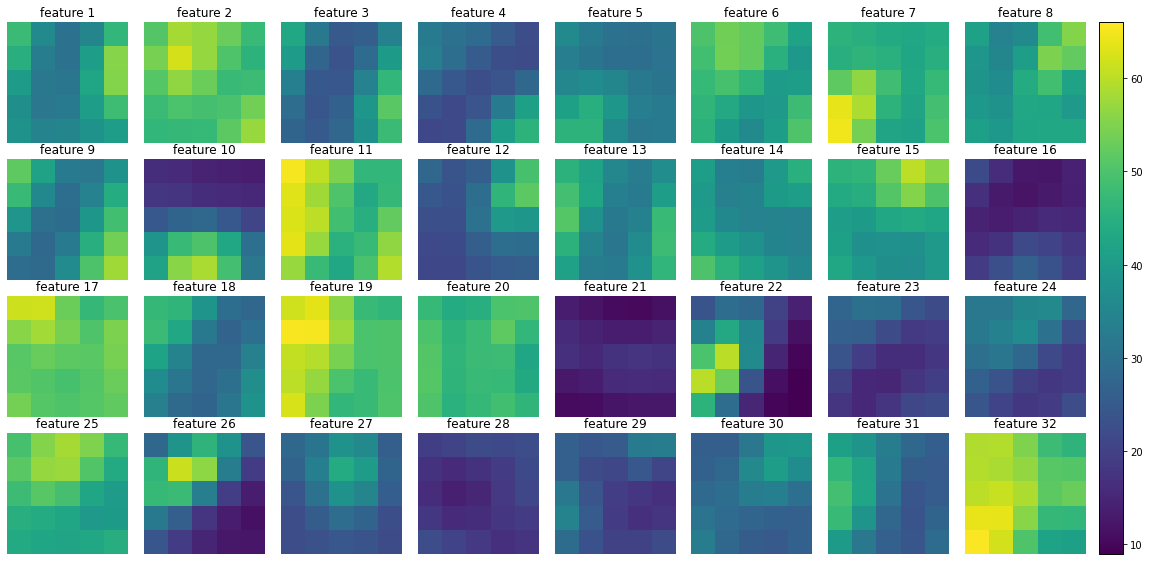

In [211]:
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = np.floor(min(list(torch.flatten(MNIST_NN_Std_prec_00001[0]))))
max_val = np.ceil(max(list(torch.flatten(MNIST_NN_Std_prec_00001[0]))))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(MNIST_NN_Std_prec_00001[0][i][0], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 10))
plt.show()

### Weights

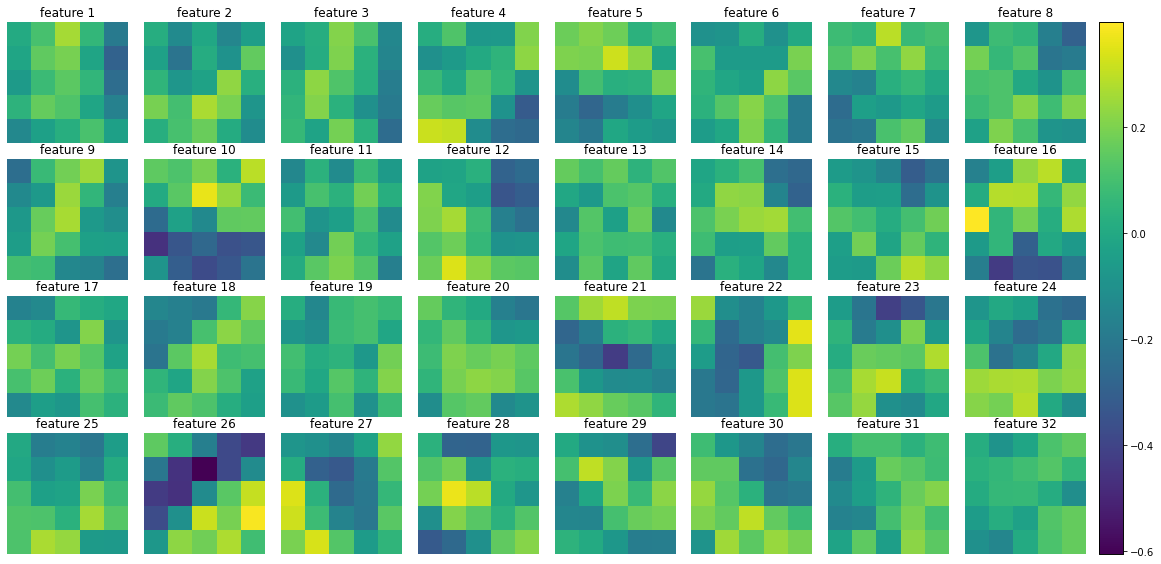

In [212]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        first_conv_weights = parameters

params_arr = first_conv_weights.detach().numpy()
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = min(list(torch.flatten(first_conv_weights).detach().numpy()))
max_val = max(list(torch.flatten(first_conv_weights).detach().numpy()))
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(params_arr[i][0], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

## Distribution of the uncertainty and weights

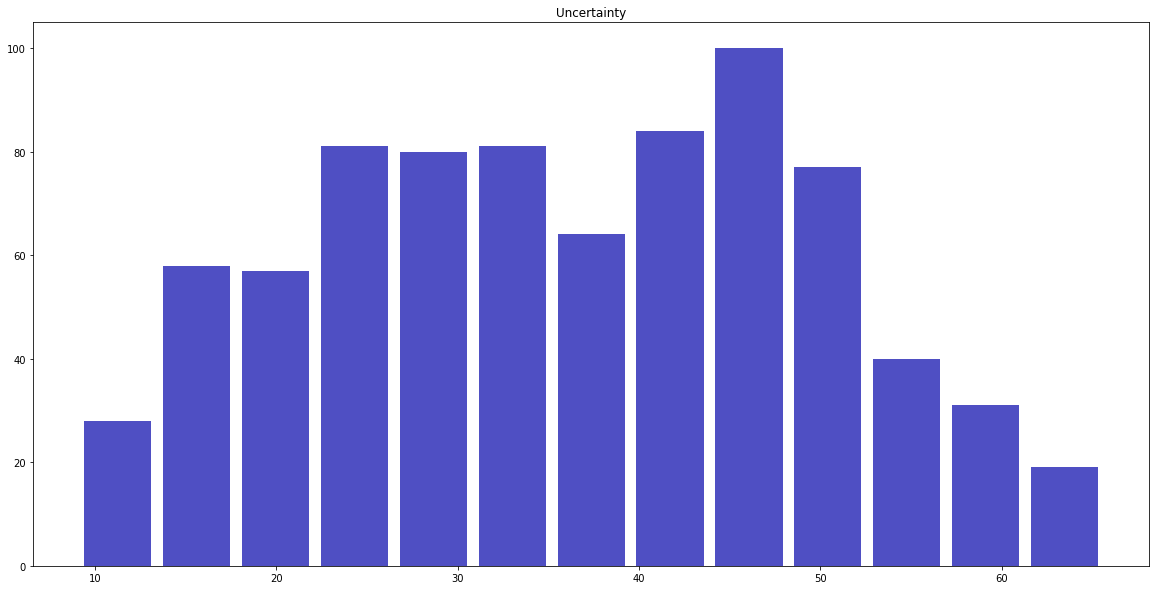

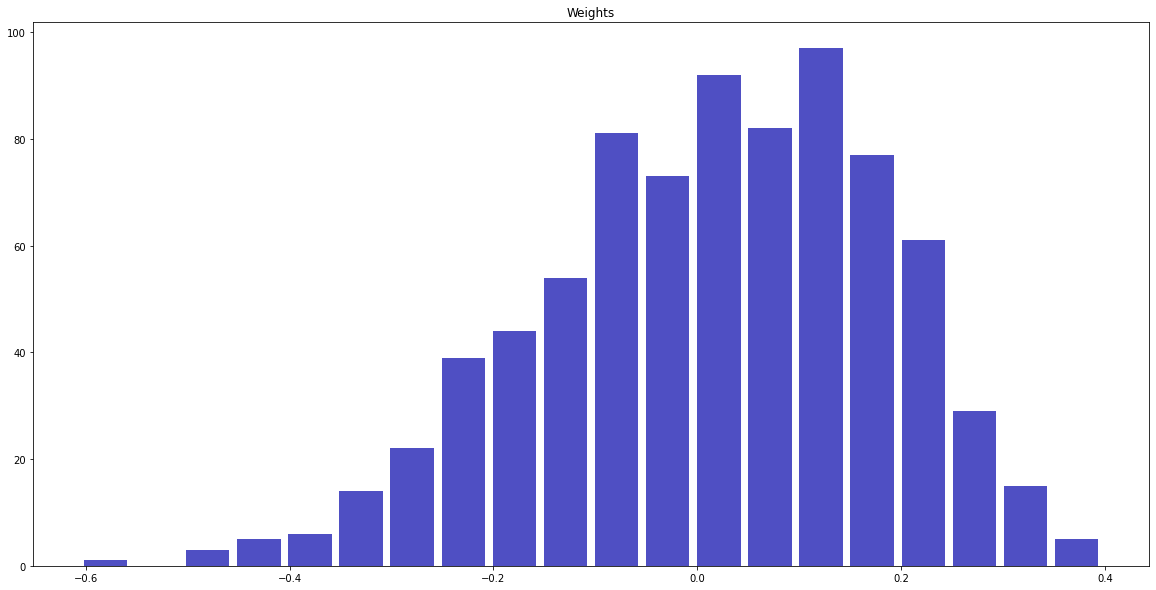

In [213]:
plt.hist(torch.flatten(MNIST_NN_Std_prec_00001[0]), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Uncertainty')
plt.show()
plt.hist(torch.flatten(first_conv_weights).detach().numpy(), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Weights')
plt.show()

## Correlation between uncertainty and size of weights


Pearsons correlation: -0.312


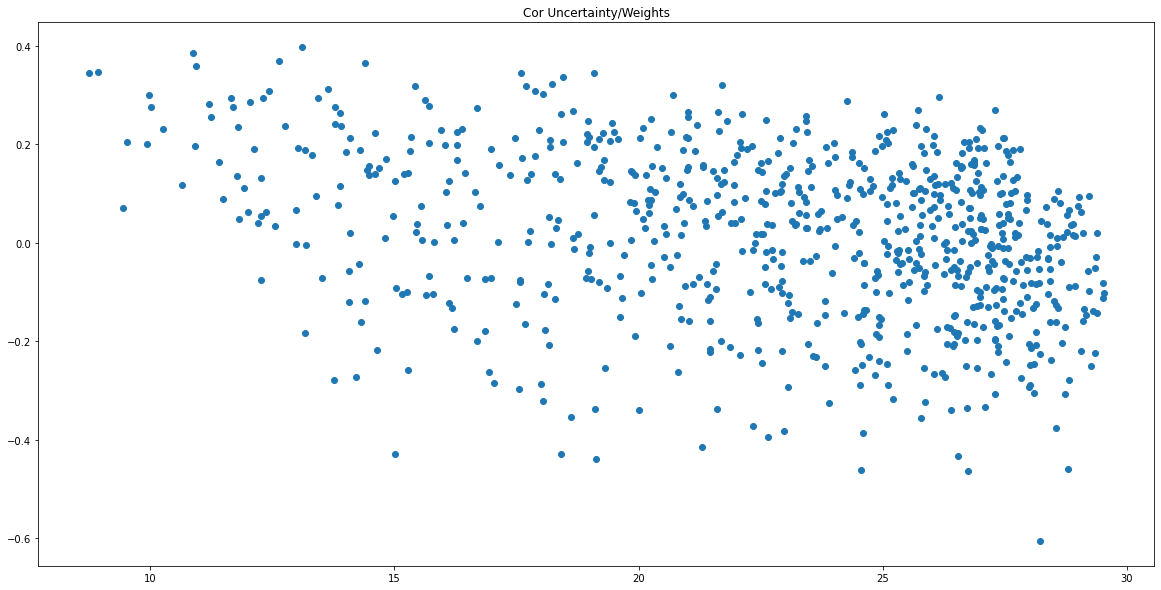

In [214]:
conv2_weights_flattened = torch.flatten(first_conv_weights)
conv2_uncertainties_flattened = torch.flatten(MNIST_NN_Std_prec_0001[0])
plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
plt.title('Cor Uncertainty/Weights')
#print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
print()
print('Pearsons correlation: %.3f' % corr)

# Analyzing the second conv-layer

## Uncertaintys

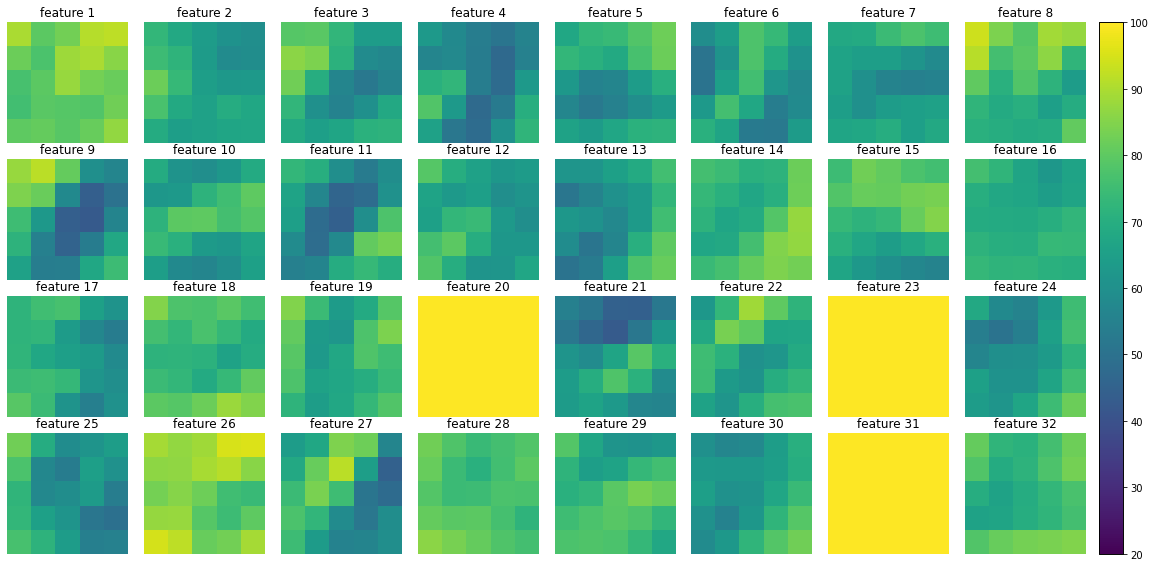

In [215]:
j = 5

fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)

for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(MNIST_NN_Std_prec_00001[2][i][j], vmin=20, vmax=100)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(20, 100, 10))
plt.show()

## Weights

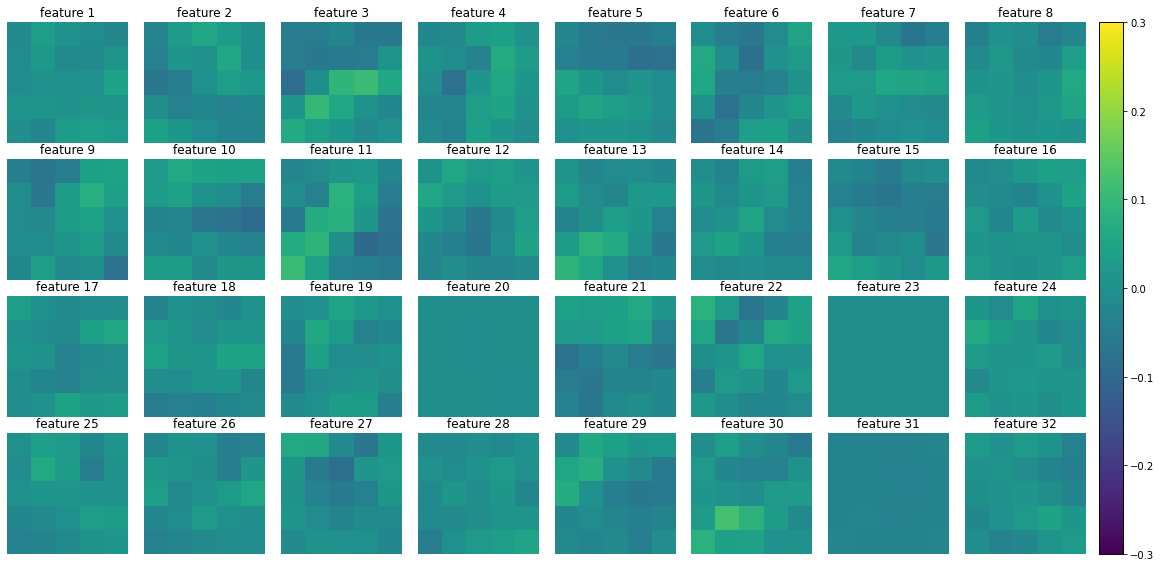

In [216]:
#j = 5
#mpl.legacy_colorbar.rcParams["mpl_toolkits.legacy_colorbar"] = False

for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        second_conv_weights = parameters

params_arr = second_conv_weights.detach().numpy()
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)
min_val = np.round(min(list(torch.flatten(second_conv_weights).detach().numpy())), 1)
max_val = np.round(max(list(torch.flatten(second_conv_weights).detach().numpy())), 1)

for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(params_arr[i][j], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.1))
plt.show()

## Distribution of the uncertainty and weights

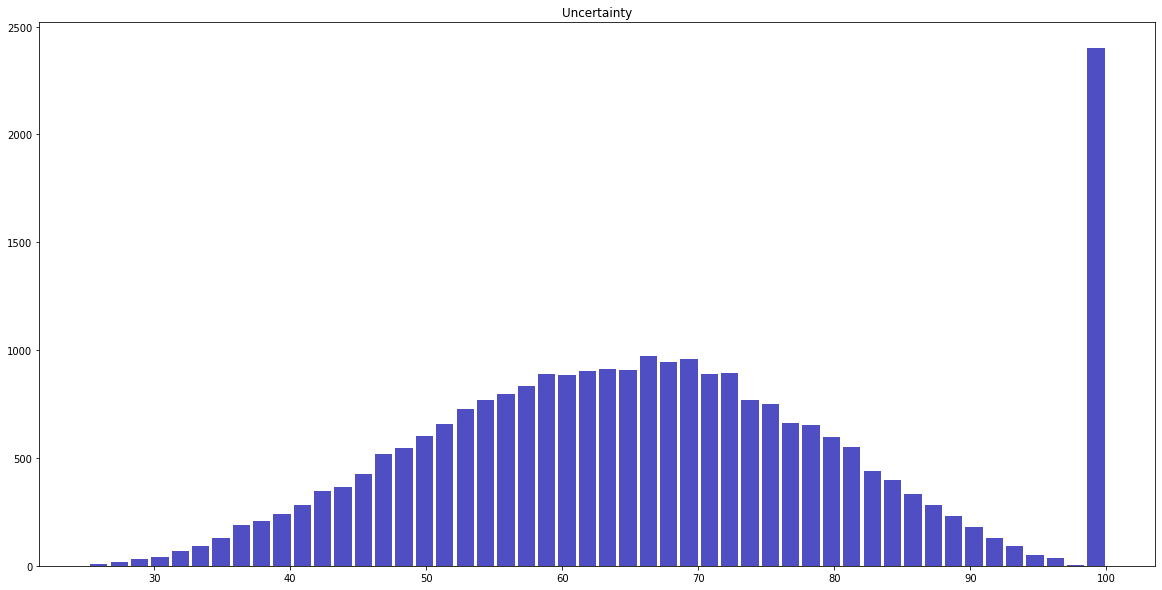

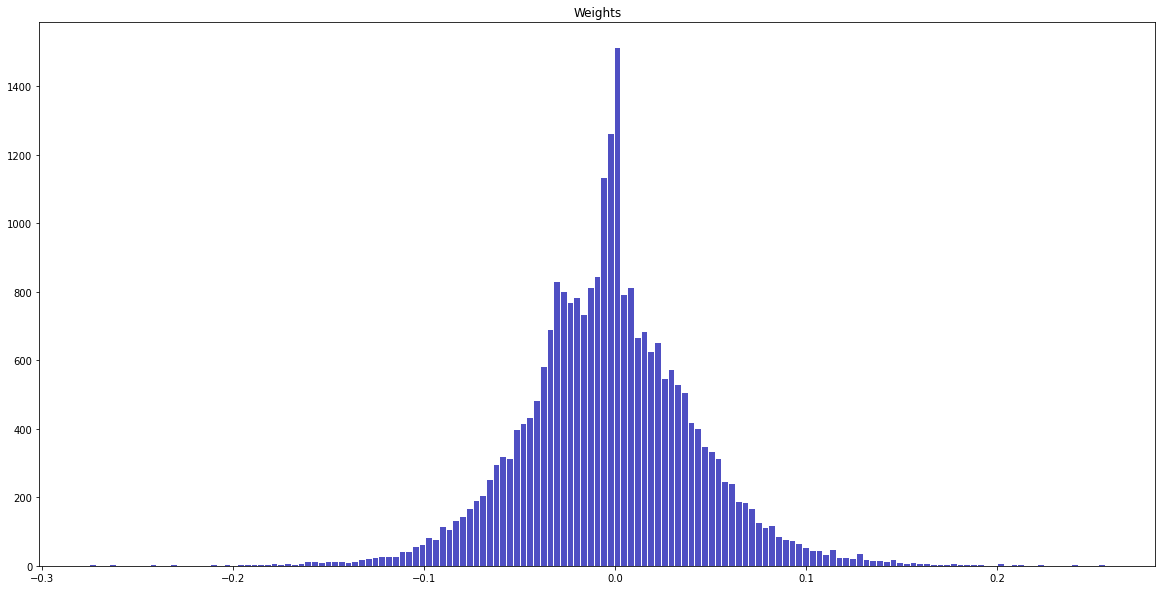

In [217]:
plt.hist(torch.flatten(MNIST_NN_Std_prec_00001[2]), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Uncertainty')
plt.show()
plt.hist(torch.flatten(second_conv_weights).detach().numpy(), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Weights')
plt.show()

## Correlation between uncertainty and size of weights

Pearsons correlation: -0.321


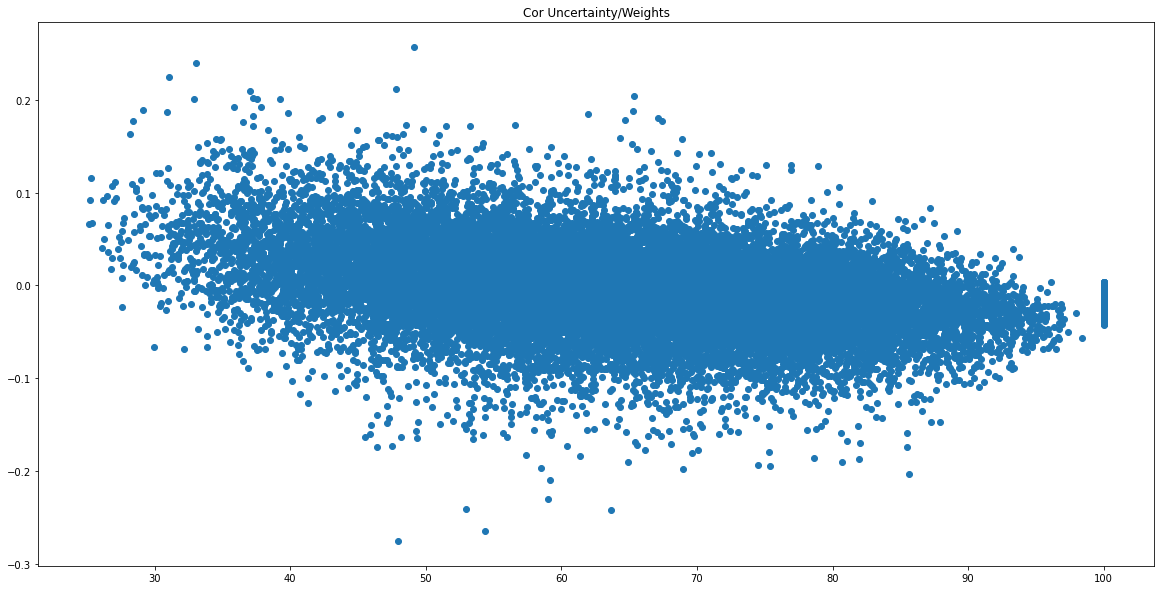

In [218]:
conv2_weights_flattened = torch.flatten(second_conv_weights)
conv2_uncertainties_flattened = torch.flatten(MNIST_NN_Std_prec_00001[2])

plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
plt.title('Cor Uncertainty/Weights')
#print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

# Analyzing the linear layer (last layer)

## Uncertainty

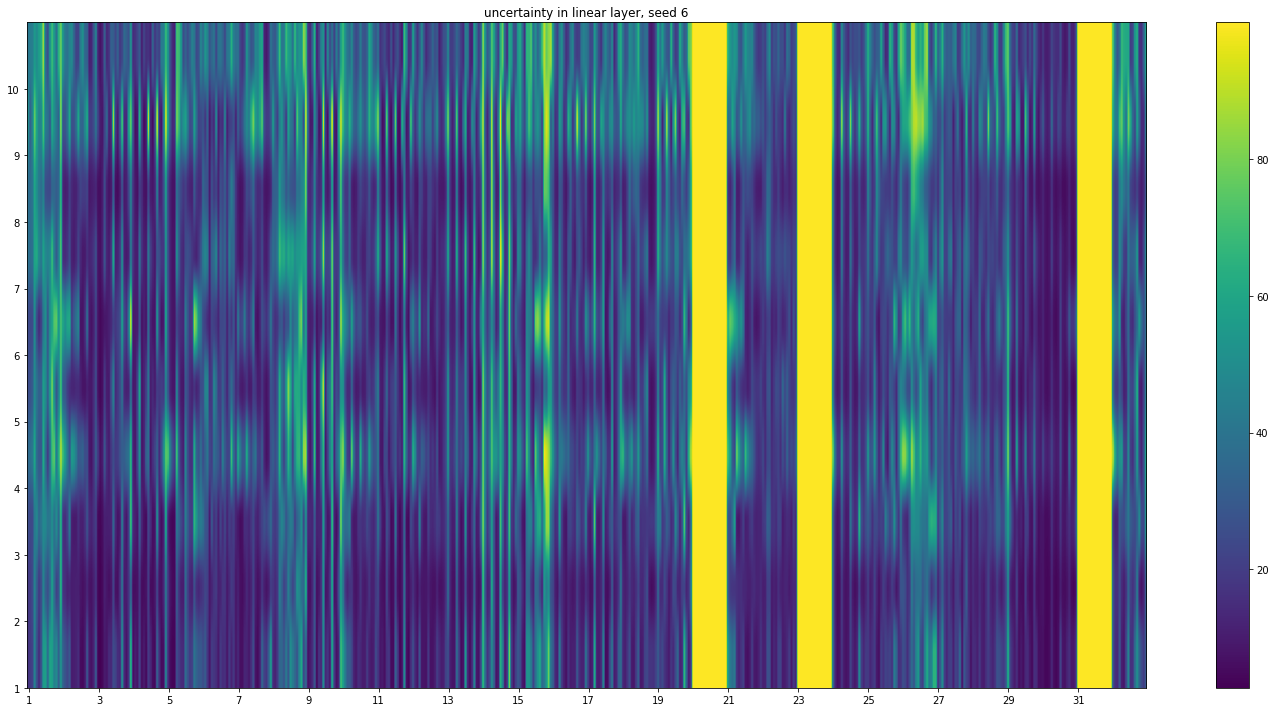

In [219]:
plt.imshow(MNIST_NN_Std_prec_00001[4], extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('uncertainty in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()

## Weights

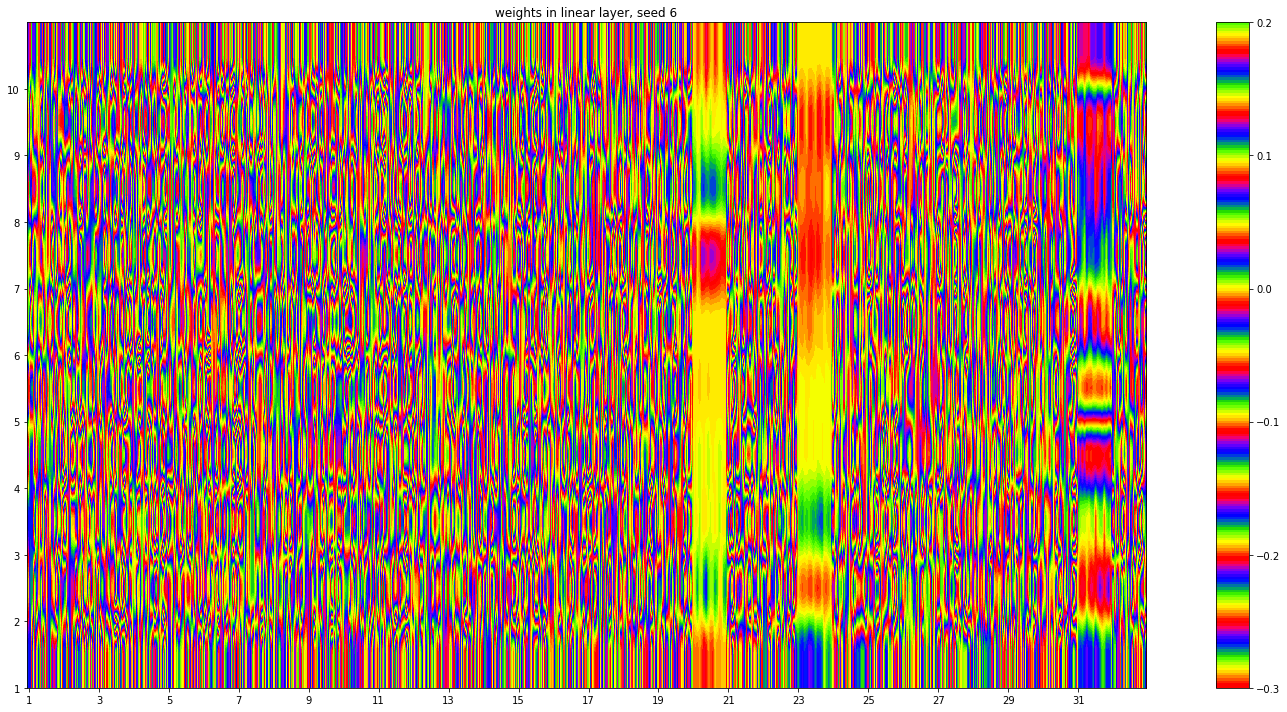

In [220]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        linear_weights = parameters

params_arr = linear_weights.detach().numpy()
min_val = np.round(min(list(torch.flatten(linear_weights).detach().numpy())), 1)
max_val = np.round(max(list(torch.flatten(linear_weights).detach().numpy())), 1)

plt.imshow(params_arr, cmap='prism', extent=[0,512,0,1],  aspect='auto', vmin=min_val, vmax=max_val)
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('weights in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()

## Distribution of uncertainty and weights

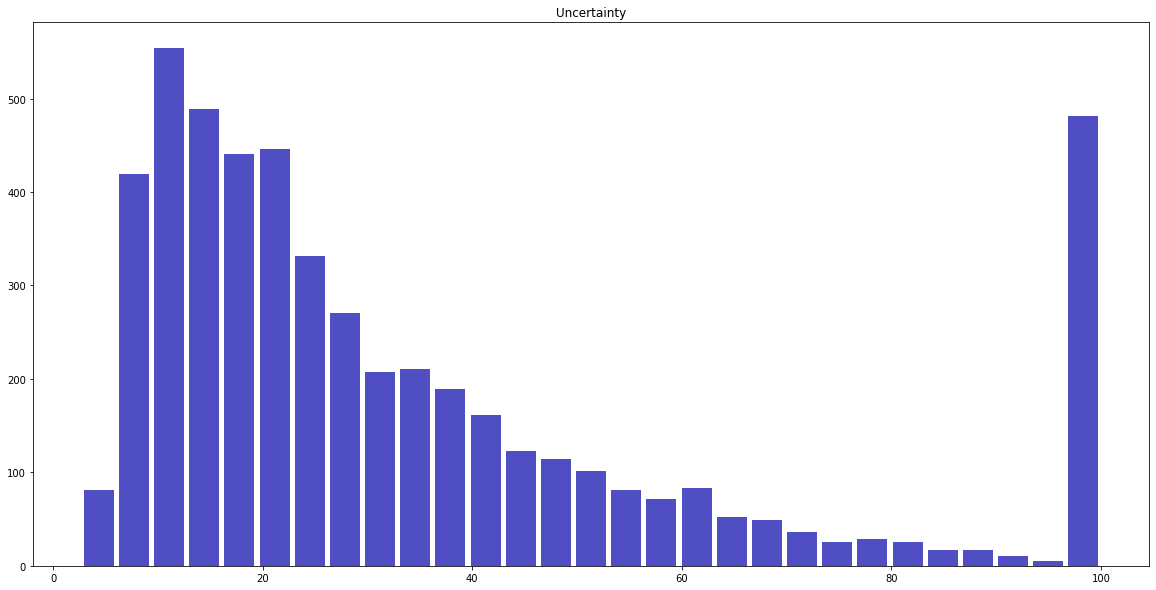

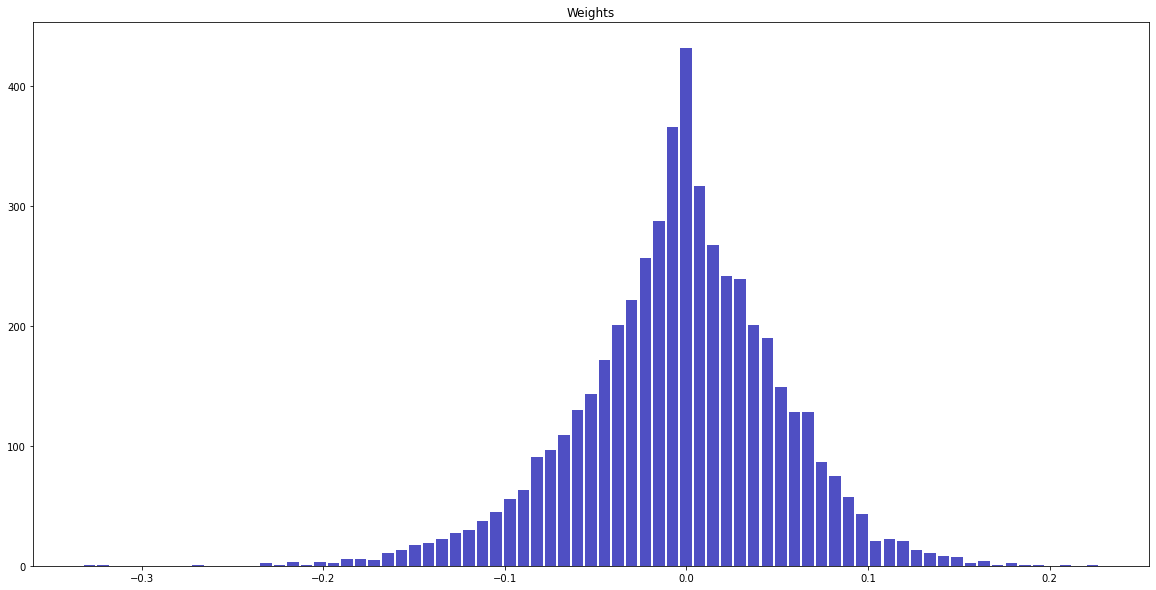

In [221]:
plt.hist(torch.flatten(MNIST_NN_Std_prec_00001[4]), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Uncertainty')
plt.show()
plt.hist(torch.flatten(linear_weights).detach().numpy(), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.title('Weights')
plt.show()

## Correlation between uncertainty and size of weights

Pearsons correlation: -0.122


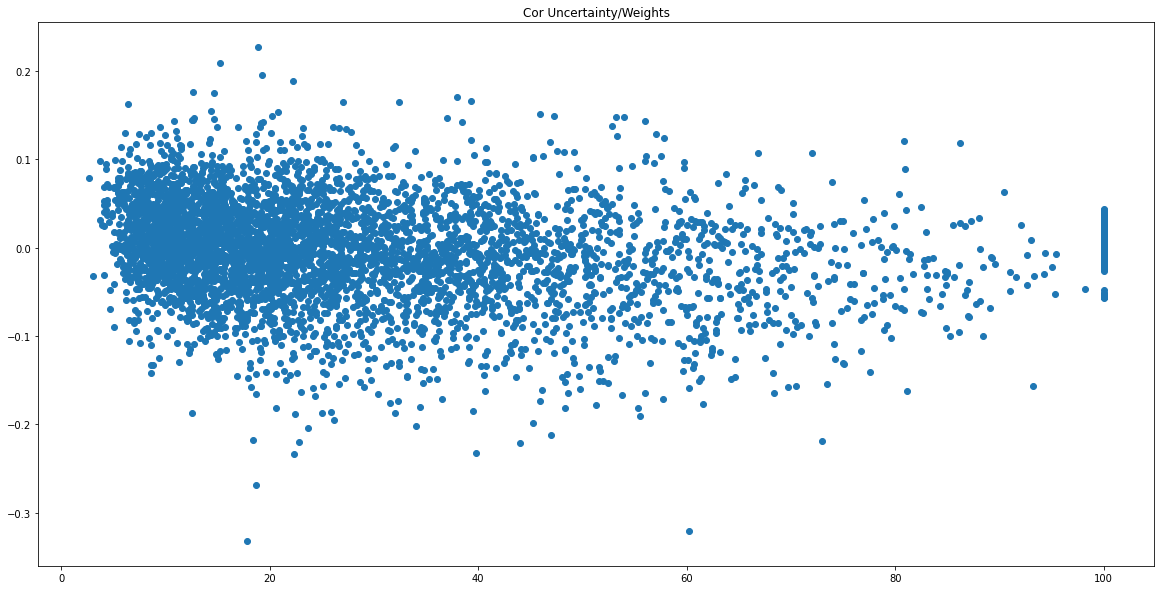

In [222]:
linear_weights_flattened = torch.flatten(linear_weights)
linear_uncertainties_flattened = torch.flatten(MNIST_NN_Std_prec_00001[4])
plt.scatter(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
plt.title('Cor Uncertainty/Weights')
corr, _ = pearsonr(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)